In [19]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

# import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor

In [20]:
# fits file use - Q,D,S cross-matched, but based on the quaia
superset = fits.open('Quaia_DESIQSO_DR1_SDSS.fits')
data = superset[1].data

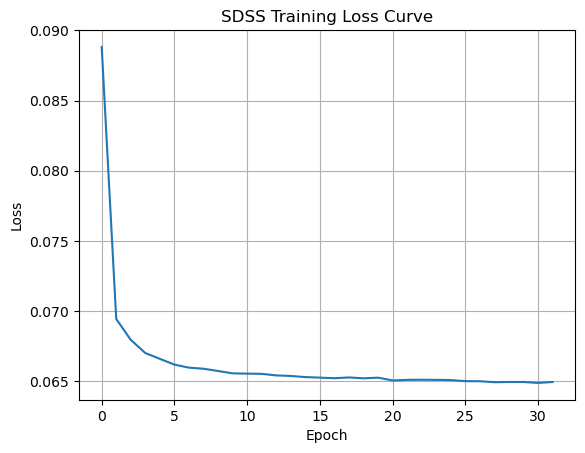

MAE: 0.2594


In [25]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg']

mask = np.ones(len(data), dtype=bool)
for f in features + ['SDSS_Z']:
    mask &= ~np.isnan(data[f])

X = np.array([data[f][mask] for f in features]).T
y = data['SDSS_Z'][mask]

# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLPRegressor 
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=200,
                   activation='relu', solver='adam', random_state=42)
mlp.fit(X_train_scaled, y_train)

# estimation
y_pred = mlp.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)

# epoch vs loss graph
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SDSS Training Loss Curve")
plt.grid(True)
plt.show()

print(f"MAE: {mae:.4f}")

In [26]:
#Quaia adjustment
apply_mask = np.ones(len(data), dtype=bool)
for f in features:
    apply_mask &= ~np.isnan(data[f])

X_quaia_full = np.array([data[f][apply_mask] for f in features]).T
X_quaia_scaled = scaler.transform(X_quaia_full)

z_phot_predictions = mlp.predict(X_quaia_scaled)

z_phot_full = np.full(len(data), np.nan)
z_phot_full[apply_mask] = z_phot_predictions

print(z_phot_predictions[:5])
print(len(z_phot_predictions))

[0.43097904 1.7471277  1.45160118 2.3881445  2.31156305]
1295502


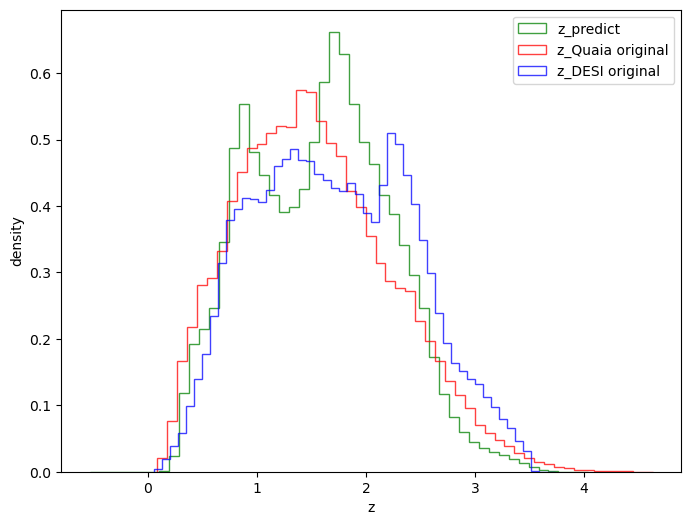

In [28]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_phot_predictions, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_DESI original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()